In [8]:
import quandl
quandl.ApiConfig.api_key = 'vcx4s9_juRgoyVT9EL-M' 

import matplotlib.pyplot as plt
from numpy import newaxis
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
import time
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [18]:
def plot_results_multiple(predicted_data, true_data, prediction_len):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    #Pad the list of predictions to shift it in the graph to it's correct start
    for i, data in enumerate(predicted_data):
        padding = [None for p in xrange(i * prediction_len)]
        plt.plot(padding + data, label='Prediction')
        plt.legend()
    plt.show()
    
def predict_point_by_point(model, data):
    #Predict each timestep given the last sequence of true data, in effect only predicting 1 step ahead each time
    predicted = model.predict(data)
    predicted = np.reshape(predicted, (predicted.size,))
    return predicted

def predict_sequence_full(model, data, window_size):
    #Shift the window by 1 new prediction each time, re-run predictions on new window
    curr_frame = data[0]
    predicted = []
    for i in xrange(len(data)):
        predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
        curr_frame = curr_frame[1:]
        curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
    return predicted

def predict_sequences_multiple(model, data, window_size, prediction_len):
    #Predict sequence of 50 steps before shifting prediction run forward by 50 steps
    prediction_seqs = []
    for i in xrange(len(data)/prediction_len):
        curr_frame = data[i*prediction_len]
        predicted = []
        for j in xrange(prediction_len):
            predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
            curr_frame = curr_frame[1:]
            curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
        prediction_seqs.append(predicted)
    return prediction_seqs

In [35]:
def load_data(quandl_id):
    data  = quandl.get(quandl_id)
    print data.columns
    data = data["Close"]
    return data.values

def normalise_data(dataset):
    scaler = MinMaxScaler(feature_range=(0, 1))
    dataset = scaler.fit_transform(dataset)
    return np.array(dataset)

def prepare_dataset(normalised_dataset, seq_length):
    sequence_length = seq_length + 1
    result = []

    for index in range(len(normalised_values) - sequence_length):
        result.append(normalised_values[index: index + sequence_length])

    result = np.array(result)

    row = round(0.9 * result.shape[0])
    train = result[:int(row), :]
    np.random.shuffle(train)
    x_train = train[:, :-1]
    y_train = train[:, -1]
    x_test = result[int(row):, :-1]
    y_test = result[int(row):, -1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1)) 
    return [x_train, y_train, x_test, y_test]

In [36]:
#Step 1 Load and Normalize data
dataset = load_data("BCHARTS/BITSTAMPUSD")

Index([u'Open', u'High', u'Low', u'Close', u'Volume (BTC)',
       u'Volume (Currency)', u'Weighted Price'],
      dtype='object')


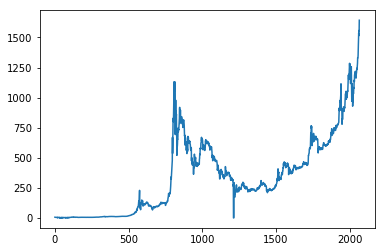

In [37]:
# Print Close values
plt.plot(dataset)
plt.show()

In [38]:
# timestamps = dataset[:,0]
normalised_values = normalise_data(dataset.reshape(-1, 1))
X_train, y_train, X_test, y_test = prepare_dataset(normalised_values, 50)

In [39]:
#Step 2 Build Model
model = Sequential()

model.add(LSTM(input_dim=1, output_dim=50, return_sequences=True))
model.add(Dropout(0.5))

model.add(LSTM(100, return_sequences=False))
model.add(Dropout(0.5))

model.add(Dense(output_dim=1))
model.add(Activation('linear'))

start = time.time()
model.compile(loss='mse', optimizer='rmsprop')
print 'compilation time : ', time.time() - start

compilation time :  0.029039144516


In [40]:
#Step 3 Train the model
model.fit(X_train, y_train, batch_size=512, nb_epoch=10, validation_split=0.05)

Train on 1722 samples, validate on 91 samples
Epoch 1/10
1722/1722 [==============================] - 4s - loss: 0.1119 - val_loss: 0.0014
Epoch 2/10
1722/1722 [==============================] - 2s - loss: 0.0076 - val_loss: 8.0399e-04
Epoch 3/10
1722/1722 [==============================] - 2s - loss: 0.0064 - val_loss: 8.1936e-04
Epoch 4/10
1722/1722 [==============================] - 2s - loss: 0.0064 - val_loss: 7.6341e-04

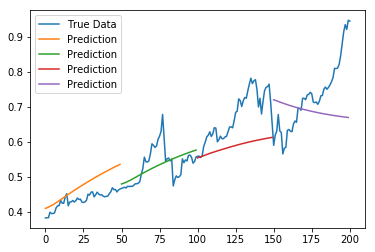

In [41]:
#Step 4 - Plot the predictions!
predictions = predict_sequences_multiple(model, X_test, 50, 50)
plot_results_multiple(predictions, y_test, 50)